In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

#### Load the Training data

In [3]:
train_dataset = torchvision.datasets.FashionMNIST(
                
    root=".",
    train = True,
    transform = transforms.ToTensor(),
    download=True

)

In [4]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [5]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [6]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

#### Loading The Testing Data

In [7]:
test_dataset = torchvision.datasets.FashionMNIST(

    root=".",
    train = False,
    transform = transforms.ToTensor(),
    download=True
)

In [8]:
### number of classes
K = len(set(train_dataset.targets.numpy()))
print("Number of Classes: ", K)

Number of Classes:  10


In [9]:
### defining the model
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers=nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
        nn.ReLU()
        )
        
        self.dense_layers = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(128 *2 *2, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, K)
        )
        
    def forward(self, X):
        out = self.conv_layers(X) # passing inputs
        out = out.view(out.size(0), -1) ## reshaping the outputs
        out = self.dense_layers(out)
        return out

In [10]:
## Instantiating the model
model = CNN(K)

In [11]:
## The same model using the newly introduced "Flatten"

# model = nn.Sequential(

#         nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
#         nn.ReLU(),
#         nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
#         nn.ReLU(),
#         nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
#         nn.ReLU(),
#         nn.Flatten(),
#         nn.Dropout(0.2),
#         nn.Linear(128 *2 *2, 512),
#         nn.ReLU(),
#         nn.Dropout(),
#         nn.Linear(512, K)
        

# )

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [13]:
## Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [14]:
## Dataloader

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle= True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size= batch_size, shuffle= False)

In [15]:
## a function o encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for i in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            ## move data to gpu
            inputs, targets = inputs.to(device), targets.to(device)
            
            
            ##zero the parameter gradient
            optimizer.zero_grad()
            
            ## forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            ##backward and optimize
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())    
        ## get the train loss and test loss
        train_loss = np.mean(train_loss) 
        
        test_loss = []
        for inputs, targets in test_loader:
            ## move data to gpu
            inputs, targets = inputs.to(device), targets.to(device)        
            ## forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
         
            test_loss.append(loss.item())    
        test_loss = np.mean(test_loss)
        
        ## saving the losses
        train_losses[i] = train_loss
        test_losses[i] = test_loss
        
        dt = datetime.now() - t0
        print(f'Epoch {i+1}/{epochs}, Train_loss: {train_loss:.4f}, \  Test_loss: {test_loss:.4f}, Duration: {dt}')
        
    return train_losses, test_losses

In [16]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs= 15)

Epoch 1/15, Train_loss: 0.6522, \  Test_loss: 0.4873, Duration: 0:00:29.387569
Epoch 2/15, Train_loss: 0.4255, \  Test_loss: 0.4199, Duration: 0:00:14.574255
Epoch 3/15, Train_loss: 0.3675, \  Test_loss: 0.3710, Duration: 0:00:13.676289
Epoch 4/15, Train_loss: 0.3368, \  Test_loss: 0.3531, Duration: 0:00:13.936072
Epoch 5/15, Train_loss: 0.3085, \  Test_loss: 0.3466, Duration: 0:00:14.159825
Epoch 6/15, Train_loss: 0.2854, \  Test_loss: 0.3323, Duration: 0:00:15.087860
Epoch 7/15, Train_loss: 0.2682, \  Test_loss: 0.3197, Duration: 0:00:15.801186
Epoch 8/15, Train_loss: 0.2501, \  Test_loss: 0.3195, Duration: 0:00:13.947899
Epoch 9/15, Train_loss: 0.2358, \  Test_loss: 0.3095, Duration: 0:00:14.130688
Epoch 10/15, Train_loss: 0.2216, \  Test_loss: 0.3075, Duration: 0:00:14.040400
Epoch 11/15, Train_loss: 0.2077, \  Test_loss: 0.3237, Duration: 0:00:13.388874
Epoch 12/15, Train_loss: 0.1968, \  Test_loss: 0.3116, Duration: 0:00:13.092145
Epoch 13/15, Train_loss: 0.1834, \  Test_loss: 0.

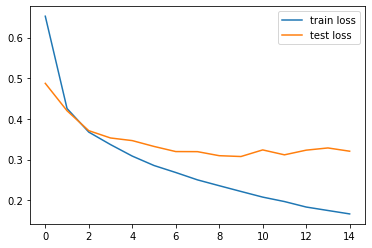

In [17]:
 ## plot the train loss and test loss per iteration
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [18]:
## accuracy
n_correct = 0
n_total = 0

for inputs, targets in train_loader:
  ## move data to gpu
  inputs, targets = inputs.to(device), targets.to(device)

  ## forward pass
  outputs = model(inputs)

  ## get the prediction
  ## torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1) 

  ## update the counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]
train_acc = n_correct / n_total

n_correct = 0
n_total = 0

for inputs, targets in test_loader:
  ## move data to gpu
  inputs, targets = inputs.to(device), targets.to(device)

  ## forward pass
  outputs = model(inputs)

  ## get the prediction
  ## torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1) 

  ## update the counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total


print(f"Train acc: {train_acc:.4f}, Test_acc: {test_acc:.4f}")

Train acc: 0.9445, Test_acc: 0.8958


In [19]:
#plot the confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion_matrix", cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix
    Normalization can be applied by normalize=True
    """
    if normalize:
        cm  = cm.astype("float")/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion matrix without normalization")
        
    print(cm)
    
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    
    fmt = ".2f" if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment = "center",
                color="white" if cm[i,j]>thresh else "black" )
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted Label")
    plt.show()

In [20]:
# get all predictions in an array and plot the confusion matrix
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])

# for inputs, targets in test_loader:
#     inputs = inputs.to(device)
#     targets = targets.to(device)
    
#     inputs = inputs.view(-1, 784)
    
#     #forward pass
#     outputs = model(inputs)
    
#     #get prediction
#     _, predictions = torch.max(outputs, 1)
    
#     # update p test
#     p_test = np.concatenate((p_test, predictions.cpu().numpy()))

# cm = confusion_matrix(y_test, p_test)
# plot_confusion_matrix(cm, list(range(10)))

In [21]:
## label mapping
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle Boot'''.split("\n")

C:\Users\Tausif\anaconda3\envs\onlyPytorch\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


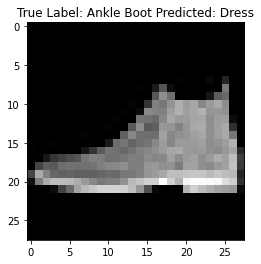

In [25]:
p_test = np.concatenate((p_test, predictions.cpu().numpy()))
p_test = p_test.astype(np.uint8)
mis_class_idx = np.where(p_test != y_test)[0]
i = np.random.choice(mis_class_idx)
plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
plt.title("True Label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));

In [26]:
import jovian

In [28]:
jovian.commit(project=("CNN Fashion MNIST"))

<IPython.core.display.Javascript object>

[jovian] Updating notebook "mdtausifc/cnn-fashion-mnist" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/mdtausifc/cnn-fashion-mnist


'https://jovian.ai/mdtausifc/cnn-fashion-mnist'